In [0]:
#library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random as rnd

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

# Importing Models
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Importing other tools
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn import preprocessing

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/insaid2018/Term-3/master/Projects/gender_recognition_by_voice.csv')
data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [0]:
data['label'].unique()

array(['male', 'female'], dtype=object)

In [0]:
data = data.drop(['sd','Q25','Q75','IQR','skew','kurt'],axis=1)

In [0]:
# Converting LABEL to Number: Female - 0 and Male - 1
data['label'] = data['label'].map( {'female': 0, 'male': 1} ).astype(int)
data['label'].unique()

array([1, 0])

In [0]:
dataDump  = data.copy()
df = dataDump.drop(['label'], axis=1)
df2 = df.drop([],axis = 1)
df3 = pd.DataFrame()
for col in df.columns:
    df3[col] = df[col].astype('category')

In [0]:
Target = ['label']
data1_x_bin = df2
data1_x_bin.head()

,meanfreq,median,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
0,0.059781,0.032027,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000
1,0.066009,0.040229,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632
2,0.077316,0.036718,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512
3,0.151228,0.158011,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119
4,0.135120,0.124656,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
#Target = ['Class']
#data1_x_bin = pd.get_dummies(df2)

# X = data1_x_bin
# y = Target
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]

#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data[Target]  # Y 

#index through MLA and save performance to table
row_index = 0
Feature_Importance = {}

for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1_x_bin, data[Target], cv  = cv_split,return_train_score=True,scoring='f1')

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1_x_bin, data[Target])

    try:
      Feature_Importance[MLA_name] = alg.feature_importances_
    except AttributeError:
      pass
      
    MLA_predict[MLA_name] = alg.predict(data1_x_bin)
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
MLA_compare['Difference'] = (MLA_compare['MLA Test Accuracy Mean']-MLA_compare['MLA Train Accuracy Mean'])*100
MLA_compare

#MLA_predict

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time,Difference
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",1,0.979086,0.00833713,0.17359,-2.09138
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1,0.97237,0.0153791,0.394807,-2.76299
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.990199,0.972086,0.0123635,0.203159,-1.81132
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.994436,0.970526,0.0130338,0.844483,-2.39109
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.981072,0.968228,0.0189945,0.231526,-1.28437
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.996943,0.965875,0.00853093,0.127068,-3.10675
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.961298,0.962168,0.00900151,1.7158,0.0870267
19,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.958297,0.958661,0.0109476,0.00932961,0.036325
8,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.957498,0.958577,0.0142591,0.00754199,0.107831
16,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.954163,0.954149,0.0177659,0.170805,-0.00137585


In [0]:
MLA_compare.sort_values(by="MLA Test Accuracy 3*STD",ascending=False)

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time,Difference
9,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.777467,0.776177,0.648745,0.0186504,-0.128951
10,Perceptron,"{'alpha': 0.0001, 'class_weight': None, 'early...",0.693891,0.697379,0.643058,0.0105954,0.348831
20,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.669049,0.660769,0.486105,0.00439641,-0.828073
7,PassiveAggressiveClassifier,"{'C': 1.0, 'average': False, 'class_weight': N...",0.890048,0.892242,0.118087,0.0137266,0.219399
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.696473,0.704659,0.0753168,1.00177,0.818586
18,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",1,0.922484,0.0590601,0.00312345,-7.75156
11,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.177399,0.185388,0.0521643,0.00390437,0.798875
12,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.852298,0.856845,0.040642,0.00274611,0.454735
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.788835,0.789598,0.0320146,3.35976,0.0762493
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.861432,0.789017,0.0270395,0.00500345,-7.24154


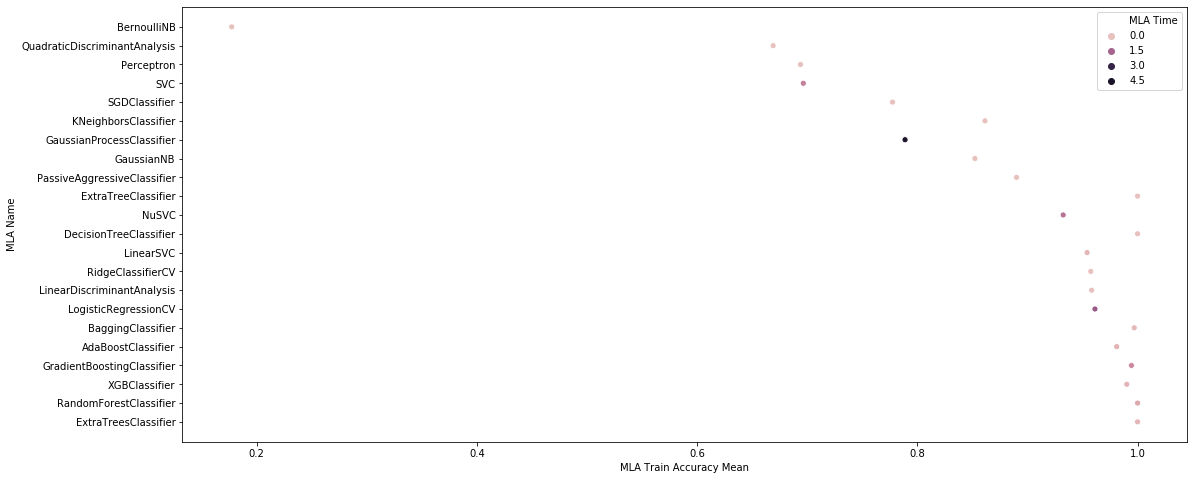

In [0]:
# sns.lineplot(x="MLA Train Accuracy Mean", y="MLA Test Accuracy Mean", hue="MLA Name", data=MLA_compare)
from matplotlib import pyplot as plt
plt.figure(figsize=(18,8))
cmap = sns.cubehelix_palette(dark=.1, light=0.8, as_cmap=True)
# cmap = sns.palplot(sns.hls_palette(8, l=.3, s=.8))
sns.scatterplot(x="MLA Train Accuracy Mean", y="MLA Name", data=MLA_compare,hue="MLA Time",palette=cmap ,sizes=(20, 200))

In [0]:
# Get Importance Feature 

feature_names = data1_x_bin.columns
feat_imp_df = pd.DataFrame.from_dict(Feature_Importance)
feat_imp_df.index = feature_names
feat_imp_df

,AdaBoostClassifier,ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier,DecisionTreeClassifier,ExtraTreeClassifier,XGBClassifier
meanfreq,0.02,0.048647,0.004060,0.043348,0.004697,0.014314,0.017220
median,0.04,0.047337,0.002210,0.031386,0.006245,0.026331,0.022175
sp.ent,0.06,0.108791,0.005098,0.100698,0.009241,0.043308,0.027404
sfm,0.12,0.064456,0.003946,0.062693,0.009851,0.062140,0.019855
mode,0.18,0.080361,0.020111,0.065361,0.013498,0.051697,0.033650
centroid,0.02,0.049378,0.005029,0.040263,0.011870,0.071798,0.000000
meanfun,0.28,0.410554,0.922396,0.538535,0.863493,0.575570,0.660555
minfun,0.08,0.029876,0.021660,0.020355,0.030495,0.039410,0.056099
maxfun,0.02,0.023448,0.000614,0.012164,0.005295,0.032222,0.017155
meandom,0.06,0.029807,0.003571,0.016987,0.013660,0.008269,0.022381


          AdaBoostClassifier  ExtraTreesClassifier  ...  XGBClassifier   Overall
meanfreq            0.071429              0.072899  ...       0.026069  0.244916
median              0.142857              0.069542  ...       0.033570  0.318739
sp.ent              0.214286              0.226971  ...       0.041486  0.723735
sfm                 0.428571              0.113397  ...       0.030058  0.773473
mode                0.642857              0.154142  ...       0.050942  1.057830

[5 rows x 8 columns]


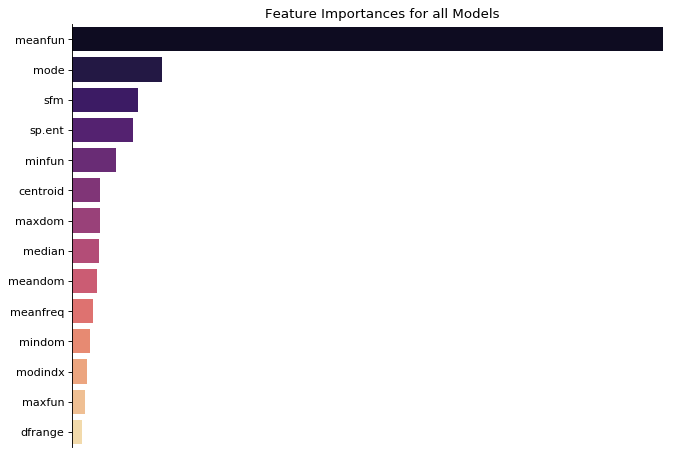

In [0]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

scaled_fi = pd.DataFrame(data=mms.fit_transform(feat_imp_df),
                         columns=feat_imp_df.columns,
                         index=feat_imp_df.index)

scaled_fi['Overall'] = scaled_fi.sum(axis=1)
print(scaled_fi.head())
ordered_ranking = scaled_fi.sort_values('Overall', ascending=False)
fig, ax = plt.subplots(figsize=(10,7), dpi=80)
sns.barplot(data=ordered_ranking, y=ordered_ranking.index, x='Overall', palette='magma')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_visible(False)
ax.grid(False)
ax.set_title('Feature Importances for all Models');

In [0]:
# Re-Building the model with only top 10 Features 

scaled_sorted = scaled_fi.sort_values(by = ['Overall'], ascending = False)
scaled_sorted[:5].index
important_col = list(scaled_sorted[:10].index)
Target = ['label']
data1_x_bin = pd.get_dummies(df2)
data1_x_bin = data1_x_bin[important_col]

# X = data1_x_bin
# y = Target
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]

#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data[Target]

#index through MLA and save performance to table
row_index = 0
Feature_Importance = {}

for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1_x_bin, data[Target], cv  = cv_split,return_train_score=True,scoring='f1')

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1_x_bin, data[Target])

    try:
      Feature_Importance[MLA_name] = alg.feature_importances_
    except AttributeError:
      pass
      
    MLA_predict[MLA_name] = alg.predict(data1_x_bin)
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
MLA_compare['Difference'] = (MLA_compare['MLA Test Accuracy Mean']-MLA_compare['MLA Train Accuracy Mean'])*100
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time,Difference
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",1,0.979528,0.0138079,0.167683,-2.04724
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.989926,0.972823,0.0113675,0.17265,-1.71034
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1,0.971784,0.012687,0.408287,-2.82157
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.994204,0.97058,0.0129028,0.694277,-2.36241
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.981449,0.9693,0.0171604,0.201809,-1.21485
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.996988,0.964697,0.0146767,0.102648,-3.22906
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.959866,0.961602,0.00999334,1.52279,0.17357
19,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.958826,0.960206,0.0105898,0.0088469,0.137968
8,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.958254,0.959218,0.011265,0.00656228,0.0963709
16,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.954808,0.954872,0.0173928,0.150235,0.00642351


Grid Search


In [0]:
# Helper Class for Initilizing GridSearch

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV

class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
        self.best_params = {}
        self.feature_importance = {}
        self.FeatureImportanceAlgo = ['DecisionTreeClassifier','RandomForestClassifier','ExtraTreesClassifier','GradientBoostingClassifier']

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=True):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs  
            self.best_params[key]  = str(gs.best_params_)
            if key in self.FeatureImportanceAlgo:
              self.feature_importance[key]= gs.best_estimator_ .feature_importances_

            # print (gs.best_params_.feature_importances_ )
            # try:
            #   print(gs.best_params_.feature_importances_ )
            #   self.feature_importance[key]= gs.best_params_.feature_importances_ 
            # except AttributeError:
            #   pass

    def returnBestParamDF(self):
      d = self.best_params
      BestParamDF = pd.DataFrame.from_dict([d.keys(), d.values()]).T
      return BestParamDF

    # def Feature_Importance(self):
    #   for each

    # def returnFeatureImportance(self):


    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

models1 = {
    
    'LogisticRegression':LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'KNNClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()
    
}

params1 = {
    'LogisticRegression': { "C":np.logspace(-3,3,7), "penalty":["l1","l2"] },  # l1 lasso l2 ridge
    'DecisionTreeClassifier': {'criterion' : ['gini', 'entropy'], 'splitter' : ['random', 'best'], 'max_depth':[2,5,10], 'min_samples_leaf':[2,5,10]},
    'RandomForestClassifier': { 'n_estimators': [16, 32] },
    'ExtraTreesClassifier': { 'n_estimators': [16, 32] },
    'KNNClassifier':{ 'n_neighbors': [5,10,15,20], 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']},
    'AdaBoostClassifier':  { 'n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] },
    'SVC': [
        {'kernel': ['linear'], 'C': [1, 10]},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    ]
}

In [0]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(data1_x_bin, data[Target], scoring='f1', n_jobs=-1)

# To run with important column
# ImpCol = ['','']
# helper1.fit(data1_x_bin[ImpCol], data[Target], scoring='f1', n_jobs=-1)

Running GridSearchCV for LogisticRegression.
Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for DecisionTreeClassifier.
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for KNNClassifier.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for SVC.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    4.8s finished


Running GridSearchCV for ExtraTreesClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.5s finished


In [0]:
feature_names = data1_x_bin.columns
feat_imp_df = pd.DataFrame.from_dict(helper1.feature_importance)
feat_imp_df.index = feature_names
feat_imp_df

,DecisionTreeClassifier,RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
meanfun,0.944089,0.632559,0.497586,0.922417
mode,0.010026,0.047802,0.070319,0.015678
sfm,0.002161,0.064301,0.082678,0.004098
sp.ent,0.002934,0.098238,0.109844,0.009321
minfun,0.021409,0.028383,0.036585,0.020034
centroid,0.000000,0.026771,0.044276,0.006380
maxdom,0.015667,0.016463,0.030221,0.007163
median,0.000000,0.031478,0.044244,0.004882
meandom,0.000914,0.014439,0.032133,0.006576
meanfreq,0.002799,0.039566,0.052115,0.003450


         DecisionTreeClassifier  ...   Overall
meanfun                1.000000  ...  4.000000
mode                   0.010620  ...  0.163695
sfm                    0.002289  ...  0.195901
sp.ent                 0.003108  ...  0.315433
minfun                 0.022677  ...  0.076898

[5 rows x 5 columns]


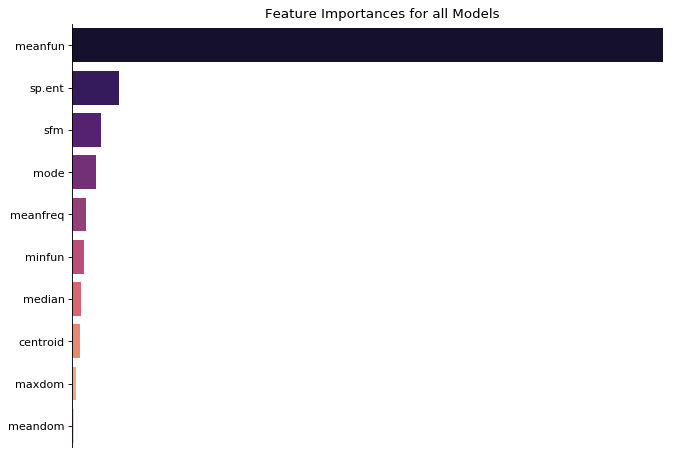

In [0]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

scaled_fi = pd.DataFrame(data=mms.fit_transform(feat_imp_df),
                         columns=feat_imp_df.columns,
                         index=feat_imp_df.index)

scaled_fi['Overall'] = scaled_fi.sum(axis=1)
print(scaled_fi.head())
ordered_ranking = scaled_fi.sort_values('Overall', ascending=False)
fig, ax = plt.subplots(figsize=(10,7), dpi=80)
sns.barplot(data=ordered_ranking, y=ordered_ranking.index, x='Overall', palette='magma')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_visible(False)
ax.grid(False)
ax.set_title('Feature Importances for all Models');

In [0]:
helper1.score_summary(sort_by='max_score')

LogisticRegression
DecisionTreeClassifier
RandomForestClassifier
KNNClassifier
SVC
ExtraTreesClassifier
AdaBoostClassifier
GradientBoostingClassifier


,estimator,min_score,mean_score,max_score,std_score,C,algorithm,criterion,gamma,kernel,learning_rate,max_depth,min_samples_leaf,n_estimators,n_neighbors,penalty,splitter
77,AdaBoostClassifier,0.940284,0.955507,0.971264,0.0126532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,NaN,NaN,NaN
50,RandomForestClassifier,0.944182,0.957755,0.970672,0.0108245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,NaN
75,ExtraTreesClassifier,0.938931,0.951569,0.969754,0.0131809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,NaN,NaN,NaN
79,GradientBoostingClassifier,0.948646,0.955939,0.968601,0.00898783,NaN,NaN,NaN,NaN,NaN,0.8,NaN,NaN,32,NaN,NaN,NaN
21,DecisionTreeClassifier,0.935238,0.949616,0.967742,0.0135316,NaN,NaN,gini,NaN,NaN,NaN,5,2,NaN,NaN,NaN,best
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,LogisticRegression,NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,l1,NaN
6,LogisticRegression,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,l1,NaN
8,LogisticRegression,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,l1,NaN
10,LogisticRegression,NaN,NaN,NaN,NaN,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,l1,NaN


In [0]:
helper1.returnBestParamDF()

,0,1
0,LogisticRegression,"{'C': 1000.0, 'penalty': 'l2'}"
1,DecisionTreeClassifier,"{'criterion': 'gini', 'max_depth': 5, 'min_sam..."
2,RandomForestClassifier,{'n_estimators': 16}
3,KNNClassifier,"{'algorithm': 'auto', 'n_neighbors': 5}"
4,SVC,"{'C': 10, 'kernel': 'linear'}"
5,ExtraTreesClassifier,{'n_estimators': 32}
6,AdaBoostClassifier,{'n_estimators': 16}
7,GradientBoostingClassifier,"{'learning_rate': 0.8, 'n_estimators': 32}"


Voting Classifier - Soft & Hard Voting

In [0]:
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    
    ('rfc', ensemble.RandomForestClassifier()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier()),
   ('lgbm',LGBMClassifier())

]

seed = 123
skf = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = seed )
#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, data1_x_bin, data[Target], cv  = skf,scoring='f1')
vote_hard.fit(data1_x_bin, data[Target])
#print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)

#   Hard Voting 
# M1    1
# M2     1
# M3     0
# M4    1

# Fina = 1 

# Soft Voting 
#     c1     c2
# M1  0.2     0.8    
# M2   0.4    0.6
# M3  0.8      0.2 

#  Soft   1.4     1.6   --> C2 (Higher) 

#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, data1_x_bin, data[Target], cv  = skf,scoring='f1')
vote_soft.fit(data1_x_bin, data[Target])

#print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Test w/bin score mean: 97.28
Hard Voting Test w/bin score 3*std: +/- 1.72
----------
Soft Voting Test w/bin score mean: 97.33
Soft Voting Test w/bin score 3*std: +/- 1.61
----------


MLExtend

In [0]:
from mlxtend.classifier import StackingClassifier


lgbm_cl = LGBMClassifier(random_state=seed)
rf_cl = RandomForestClassifier(10, random_state=seed)
gdb_cl = GradientBoostingClassifier(random_state=seed)
# logreg = LogisticRegression()


sclf = StackingClassifier(classifiers=[lgbm_cl,gdb_cl],
                          meta_classifier=rf_cl)


scores = model_selection.cross_val_score(sclf, data1_x_bin, data[Target], 
                                              cv=3, scoring='f1')
print("Accuracy: %0.2f (+/- %0.2f)" 
      % (scores.mean(), scores.std()))
    

# label = ['LGBM', 'Random Forest','GDB' 'Stacking Classifier']
# clf_list = [lgbm_cl, rf_cl,gdb_cl, logreg]

# for clf, label in zip([lgbm_cl, rf_cl,gdb_cl,sclf], 
#                       ['LGBM', 
#                        'Random Forest', 
#                        'GDB',
#                        'StackingClassifier']):

#     scores = model_selection.cross_val_score(clf, data1_x_bin, data[Target], 
#                                               cv=3, scoring='f1')
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
#           % (scores.mean(), scores.std(), label))

Accuracy: 0.96 (+/- 0.01)


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data1_x_bin, data[Target], test_size=0.2)

dtree = GradientBoostingClassifier()
dtree.fit(X_train, y_train)
dtree.predict(X_test)

array([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,

In [0]:
from sklearn.metrics import f1_score
f1_score(y_test, dtree.predict(X_test))

0.9705426356589147

In [0]:
import eli5

from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data1_x_bin, data[Target], test_size=0.2)

dtree = RandomForestClassifier()
dtree.fit(X_train, y_train)
dtree.predict(X_test)
perm = PermutationImportance(dtree , random_state=101).fit(X_test, y_test)      # Evaluate the permutation importance 
eli5.show_weights(perm, feature_names = X_test.columns.values)    

Using TensorFlow backend.


Weight,Feature
0.4451 ± 0.0369,meanfun
0.0120 ± 0.0015,mode
0.0082 ± 0.0046,minfun
0.0054 ± 0.0015,median
0.0038 ± 0.0047,sfm
0.0035 ± 0.0050,maxdom
0.0019 ± 0.0024,meandom
0.0016 ± 0.0072,sp.ent
-0.0006 ± 0.0043,meanfreq
-0.0006 ± 0.0032,centroid
